In [7]:
# pandas
import pandas as pd
from pandas import Series,DataFrame

# numpy, matplotlib, seaborn
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')
%matplotlib inline

from IPython.display import display

# remove warnings
import warnings
warnings.filterwarnings('ignore')

# Load and pick Datas

In [8]:
train_data = pd.read_csv("data/train.csv")
test_data = pd.read_csv("data/test.csv")

display(train_data.head(1))
# display(train_data.info())

display(test_data.head(1))
# display(test_data.info())

(1460, 81)


,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500


(1459, 80)


,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,1461,20,RH,80.0,11622,Pave,NaN,Reg,Lvl,AllPub,...,120,0,NaN,MnPrv,NaN,0,6,2010,WD,Normal


In [9]:
previous_num_columns = train_data.select_dtypes(
    exclude=["object"]
).columns.values.tolist()
previous_num_columns.remove("Id")
previous_num_columns.remove("SalePrice")

['MSSubClass', 'LotFrontage', 'LotArea', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd', 'Fireplaces', 'GarageYrBlt', 'GarageCars', 'GarageArea', 'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea', 'MiscVal', 'MoSold', 'YrSold']


train: (1,)
test: (0,)


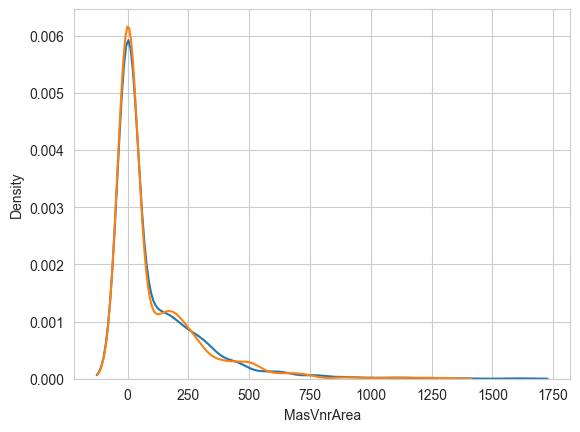

In [10]:
test_column = "MasVnrArea"
sns.kdeplot(train_data[test_column])
sns.kdeplot(test_data[test_column])

测试集中不存在一定范围的数据，而训练集中存在少量数据，将其从训练集中删除。

- LotFrontage: 训练集中存在2条大于200的记录，测试集中没有
- LotArea   : 训练集中存在5条大于70000的记录，测试集中没有
- MasVnrArea : 训练集中存在1条大于1500的记录，测试集中没有

In [11]:
train_data.drop(train_data[train_data["LotFrontage"] > 200].index, inplace=True)
train_data.drop(train_data[train_data["LotArea"] > 70000].index, inplace=True)
train_data.drop(train_data[train_data["MasVnrArea"] > 1500].index, inplace=True)

train_length = train_data.shape[0]

(1460, 81)
(1452, 81)


测试集和训练集合并

In [12]:
conbined_data = pd.concat([train_data.loc[:, :"SalePrice"], test_data])
conbined_data = conbined_data[test_data.columns]
display(conbined_data.head(1))

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,0,NaN,NaN,NaN,0,2,2008,WD,Normal


(2911, 80)


# Filling up missing values

In [13]:
# miss data columns
has_null_columns = conbined_data.columns[conbined_data.isnull().any()].tolist()
# how many data missed each column of train/test/conbine datas
train_null = train_data[has_null_columns].isnull().sum()
test_null = test_data[has_null_columns].isnull().sum()
conbined_null = conbined_data[has_null_columns].isnull().sum()

print("how many data missed each column of train/test/conbine datas")
missed_data = pd.DataFrame(
    data=[train_null, test_null, conbined_null],
    index=["train", "test", "conbine"],
    columns=has_null_columns,
)
missed_data

how many data missed each column of train/test/conbine datas


,MSZoning,LotFrontage,Alley,Utilities,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,BsmtQual,BsmtCond,...,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PoolQC,Fence,MiscFeature,SaleType
train,0,256,1362,0,0,0,868,8,37,37,...,81,81,0,0,81,81,1446,1171,1400,0
test,4,227,1352,2,1,1,894,15,44,45,...,78,78,1,1,78,78,1456,1169,1408,1
conbine,4,483,2714,2,1,1,1762,23,81,82,...,159,159,1,1,159,159,2902,2340,2808,1


In [14]:
def fill_missing_conbined_data(column, value):
    conbined_data.loc[conbined_data[column].isnull(), column] = value

** LotFrontage/LotArea **

对于缺失的 LotFrontage（Linear feet of street connected to property），一般采用平均值进行填充，但考虑到可能与 不同的 Neighborhood 有关系。

<Axes: xlabel='Neighborhood'>

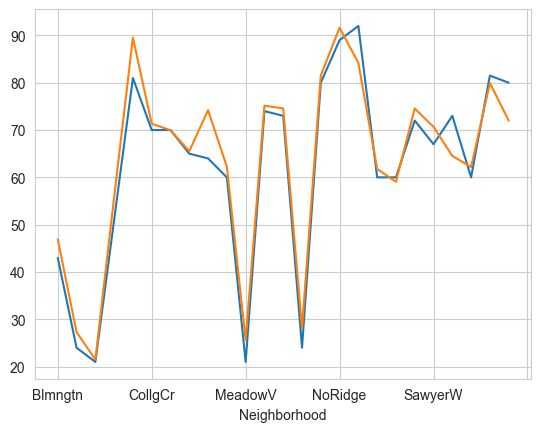

In [15]:
conbined_data["LotFrontage"].groupby(conbined_data["Neighborhood"]).median().plot()
conbined_data["LotFrontage"].groupby(conbined_data["Neighborhood"]).mean().plot()

In [16]:
lf_neighbor_map = (
    conbined_data["LotFrontage"].groupby(conbined_data["Neighborhood"]).median()
)

rows = conbined_data["LotFrontage"].isnull()
conbined_data["LotFrontage"][rows] = conbined_data["Neighborhood"][rows].map(
    lambda neighbor: lf_neighbor_map[neighbor]
)

In [17]:
conbined_data[conbined_data["LotFrontage"].isnull()]

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition


** Alley **

In [18]:
conbined_data.shape, conbined_data[conbined_data["Alley"].isnull()].shape

((2911, 80), (2714, 80))

2919 条数据缺失 2721 条，缺失数据过多(93.2%),将缺失数据填充为 NA（NA->No alley access）。

In [19]:
fill_missing_conbined_data("Alley", "NA")

** MasVnrType / MasVnrArea **

方形单板砌体类型/面积，将缺失数据填充为出现次数最多的类型

In [20]:
conbined_data["MasVnrType"].fillna("None", inplace=True)
conbined_data["MasVnrArea"].fillna(0, inplace=True)

** BsmtQual / BsmtCond / BsmtExposure / BsmtFinType1 / BsmtFinType2 **

缺失 37 / 38 条数据。

In [21]:
basement_cols = [
    "BsmtQual",
    "BsmtCond",
    "BsmtExposure",
    "BsmtFinType1",
    "BsmtFinType2",
    "BsmtFinSF1",
    "BsmtFinSF2",
]

In [22]:
# 对于缺失的字符串类型的数据填充为 NA，表示 No Basement
for column in basement_cols:
    if "FinSF" not in column:
        # NA	No Basement
        fill_missing_conbined_data(column, "NA")

In [23]:
# 对于数值型的 BsmtFinSF1 和 BsmtFinSF2
fill_missing_conbined_data("BsmtFinSF1", 0)
fill_missing_conbined_data("BsmtFinSF2", 0)

** Electrical **

缺失一条数据,填充为出现次数最多的。

<Axes: xlabel='count', ylabel='Electrical'>

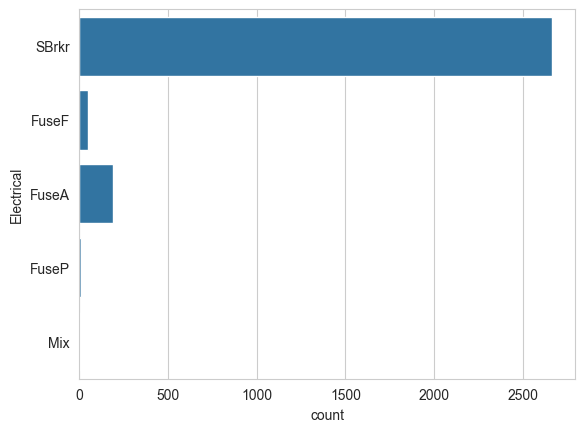

In [24]:
sns.countplot(conbined_data["Electrical"])

In [25]:
fill_missing_conbined_data("Electrical", "SBrkr")

** FireplaceQu **

缺失 1420 条数据

In [26]:
# 对于 Fireplaces 为 0 的，FireplaceQu 设置为 NA，表示 No Fireplace，此即缺失的 1420 条数据的情况
fill_missing_conbined_data("FireplaceQu", "NA")

** PoolQC **

PoolQC 缺失 2909 条数据，是否与 PoolArea 有关。

In [27]:
fill_missing_conbined_data("PoolQC", "NA")

** MiscFeature **

In [28]:
fill_missing_conbined_data("MiscFeature", "NA")

** Fence **

In [29]:
fill_missing_conbined_data("Fence", "NA")

** Garages **

In [30]:
garage_cols = [
    "GarageType",
    "GarageQual",
    "GarageCond",
    "GarageYrBlt",
    "GarageFinish",
    "GarageCars",
    "GarageArea",
]
conbined_data[garage_cols][conbined_data["GarageType"].isnull() == True].head(1)

,GarageType,GarageQual,GarageCond,GarageYrBlt,GarageFinish,GarageCars,GarageArea
39,NaN,NaN,NaN,NaN,NaN,0.0,0.0


In [31]:
# 对于缺失的字符串类型的数据填充为 NA，表示 No Garage
for column in garage_cols:
    if column != "GarageCars" and column != "GarageArea":
        # NA	No Basement
        fill_missing_conbined_data(column, "NA")
    else:
        fill_missing_conbined_data(column, 0)

** MSZoning **

<Axes: xlabel='count', ylabel='MSZoning'>

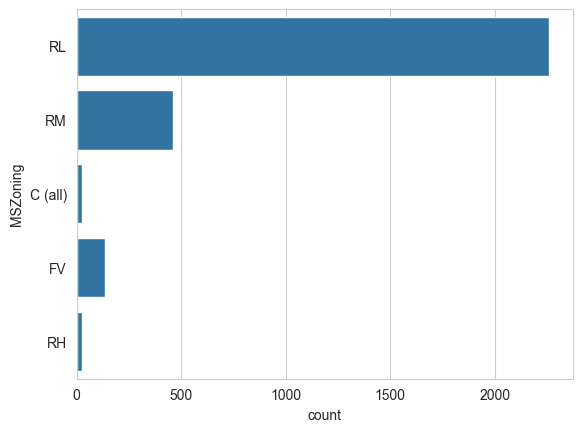

In [32]:
sns.countplot(conbined_data["MSZoning"])

In [33]:
fill_missing_conbined_data("MSZoning", "RL")

** Utilities **

**Definitely ignoring Utilities** : all records are "AllPub", except for one "NoSeWa" in the train set and 2 NA in the test set.

<Axes: xlabel='count', ylabel='Utilities'>

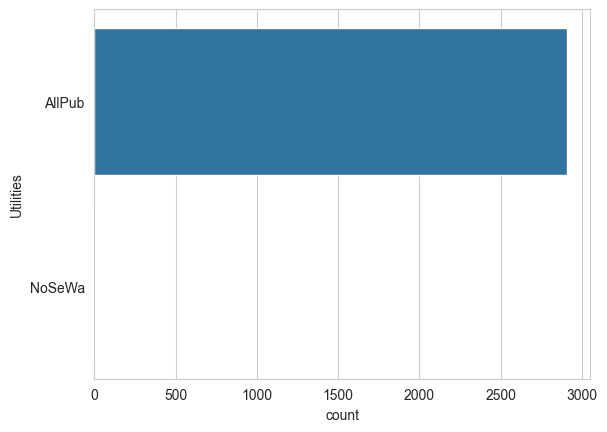

In [34]:
sns.countplot(conbined_data["Utilities"])

In [35]:
fill_missing_conbined_data("Utilities", "AllPub")

** Exterior1st / Exterior2nd**

<Axes: xlabel='count', ylabel='Exterior1st'>

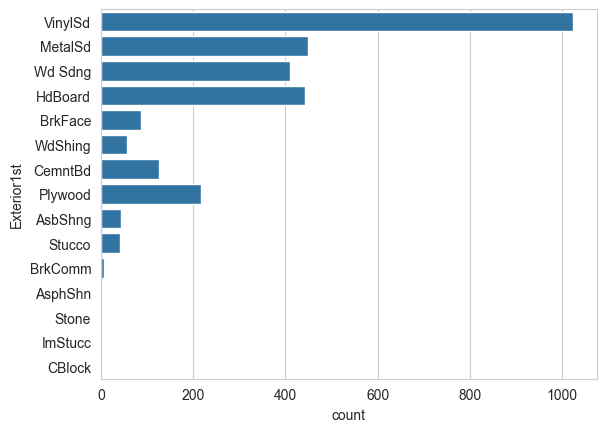

In [36]:
sns.countplot(conbined_data["Exterior1st"])

In [37]:
fill_missing_conbined_data("Exterior1st", "VinylSd")

<Axes: xlabel='count', ylabel='Exterior2nd'>

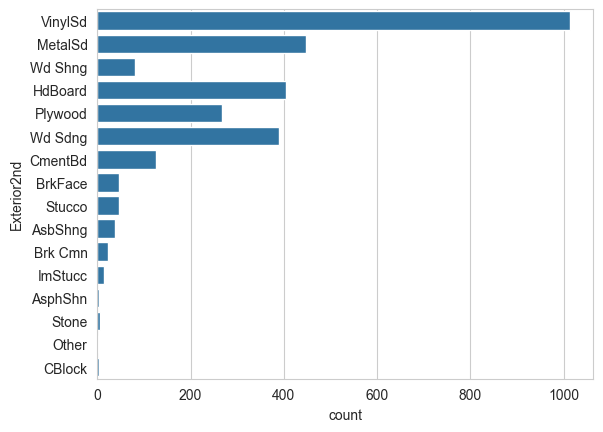

In [38]:
sns.countplot(conbined_data["Exterior2nd"])

In [39]:
fill_missing_conbined_data("Exterior2nd", "VinylSd")

** BsmtUnfSF / TotalBsmtSF **

In [40]:
# 可以发现，对于缺失的 TotalBsmtSF 和 BsmtUnfSF 填充为0
fill_missing_conbined_data("BsmtUnfSF", 0)
fill_missing_conbined_data("TotalBsmtSF", 0)

** BsmtFullBath / BsmtHalfBath **

In [41]:
fill_missing_conbined_data("BsmtFullBath", 0)
fill_missing_conbined_data("BsmtHalfBath", 0)

** KitchenQual **

<Axes: xlabel='count', ylabel='KitchenQual'>

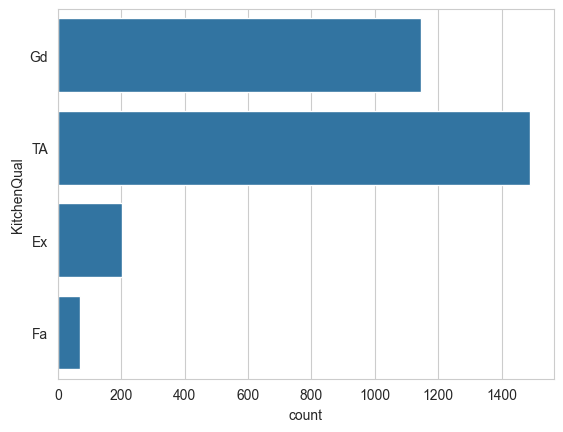

In [42]:
sns.countplot(conbined_data["KitchenQual"])

In [43]:
fill_missing_conbined_data("KitchenQual", "TA")

** SaleType / Functional **

<Axes: xlabel='count', ylabel='Functional'>

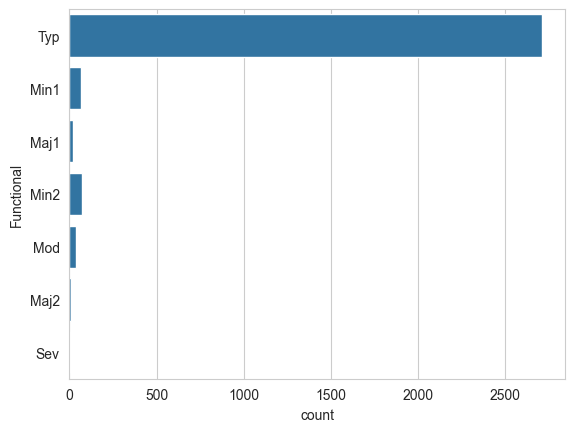

In [44]:
sns.countplot(conbined_data["Functional"])

In [45]:
fill_missing_conbined_data("SaleType", "WD")
fill_missing_conbined_data("Functional", "Typ")

完成了缺失数据的填充。

In [46]:
# 存在缺失数据的列名
has_null_columns = conbined_data.columns[conbined_data.isnull().any()].tolist()
# 每列包含多少缺失数据
conbined_data[has_null_columns].isnull().sum()

Series([], dtype: float64)

# Feature Engineering

** 时间属性（YearBuilt、GarageYrBlt）**

In [47]:
built_year_data = conbined_data[["YearBuilt", "GarageYrBlt"]][
    conbined_data["GarageYrBlt"] != "NA"
]

In [48]:
built_year_data["GarageYrBlt"] = built_year_data["GarageYrBlt"].map(lambda g: int(g))
built_year_data["GarageYrBlt"].corr(built_year_data["YearBuilt"])

0.8346885266144003

可以发现 YearBuilt、GarageYrBlt 之间存在很高的相关性。

In [49]:
built_year_data.head(1)

,YearBuilt,GarageYrBlt
0,2003,2003


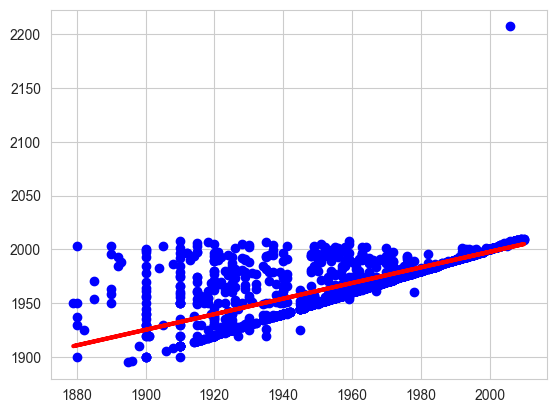

In [50]:
from sklearn.linear_model import LinearRegression



regr = LinearRegression()


garage_year = built_year_data.loc[:, "GarageYrBlt"].values


built_year = built_year_data.loc[:, "YearBuilt"].values



length = garage_year.shape[0]


garage_year = garage_year.reshape(length, 1)


built_year = built_year.reshape(length, 1)



# Train the model using the training sets


regr.fit(built_year, garage_year)


plt.scatter(built_year, garage_year, color="blue")


plt.plot(built_year, regr.predict(built_year), color="red", linewidth=3)

In [55]:
# 对于 NA 的 GarageYrBlt，进行填充
conbined_data["GarageYrBlt"] = conbined_data.apply(
    lambda row: (
        int(regr.predict(np.array([[row["YearBuilt"]]])))
        if row["GarageYrBlt"] == "NA"
        else int(row["GarageYrBlt"])
    ),
    axis=1,
)

In [56]:
conbined_data["GarageYrBlt"].head()

0    2003
1    1976
2    2001
3    1998
4    2000
Name: GarageYrBlt, dtype: int64

YearBuilt建造时间，YearRemodAdd修建时间，确定是否翻新改造过

In [57]:
# How many years has remoded from built
conbined_data["RemodYears"] = conbined_data["YearRemodAdd"] - conbined_data["YearBuilt"]
# Did a remodeling happened from built?
conbined_data["HasRemodeled"] = (
    conbined_data["YearRemodAdd"] != conbined_data["YearBuilt"]
) * 1
# Did a remodeling happen in the year the house was sold?
conbined_data["HasRecentRemodel"] = (
    conbined_data["YearRemodAdd"] == conbined_data["YrSold"]
) * 1

In [58]:
conbined_data["GarageBltYears"] = (
    conbined_data["GarageYrBlt"] - conbined_data["YearBuilt"]
)

In [59]:
conbined_data["GarageBltYears"].head()

0     0
1     0
2     0
3    83
4     0
Name: GarageBltYears, dtype: int64

In [60]:
# How many years has build now?
conbined_data["Now_YearBuilt"] = 2017 - conbined_data["YearBuilt"]
conbined_data["Now_YearRemodAdd"] = 2017 - conbined_data["YearRemodAdd"]
conbined_data["Now_GarageYrBlt"] = 2017 - conbined_data["GarageYrBlt"]

In [61]:
conbined_data[["Now_YearBuilt", "Now_YearRemodAdd", "Now_GarageYrBlt"]].head(3)

,Now_YearBuilt,Now_YearRemodAdd,Now_GarageYrBlt
0,14,14,14
1,41,41,41
2,16,15,16


- 房子卖的月份存在旺季
- 房子卖的月份为数值类型，将其转为字符串类型

<Axes: xlabel='MoSold'>

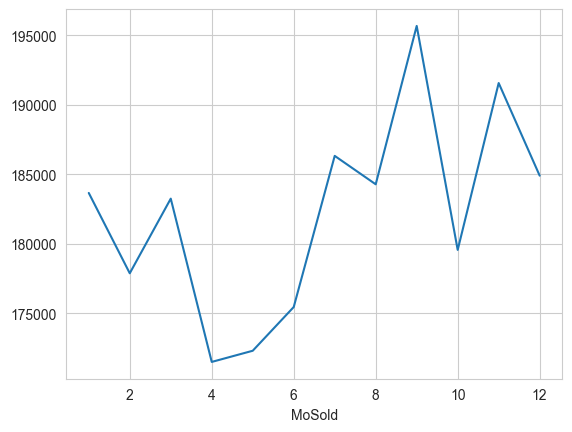

In [62]:
train_data["SalePrice"].groupby(train_data["MoSold"]).mean().plot()

<Axes: ylabel='count'>

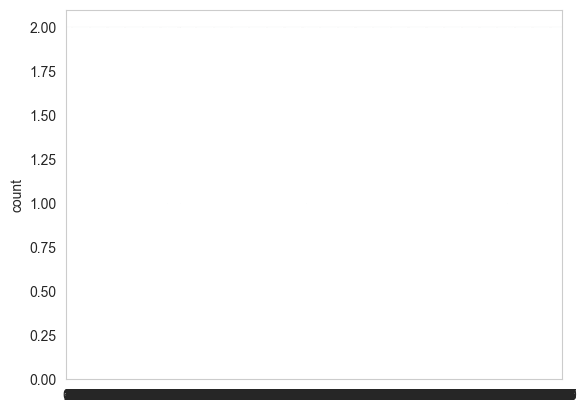

In [63]:
sns.countplot(conbined_data["MoSold"])

可以看出每月卖出房屋的数量和价格基本成反比。

In [64]:
sale_price_month = (
    train_data["SalePrice"].groupby(train_data["MoSold"]).mean().to_dict()
)
# 该月卖的平均价格
conbined_data["MonthSaledMeanPrice"] = conbined_data["MoSold"].replace(sale_price_month)

In [65]:
# 统计每月卖的数量
sale_month = {
    "1": 0,
    "2": 0,
    "3": 0,
    "4": 0,
    "5": 0,
    "6": 0,
    "7": 0,
    "8": 0,
    "9": 0,
    "10": 0,
    "11": 0,
    "12": 0,
}
for m in conbined_data["MoSold"].values:
    sale_month[str(m)] = sale_month[str(m)] + 1

In [66]:
# 月份为数值类型，将其转为字符串类型
conbined_data["MoSold"] = conbined_data["MoSold"].map(lambda m: str(m))

In [67]:
# 该月卖的数量
conbined_data["MonthSaledCount"] = conbined_data["MoSold"].replace(sale_month)

**对于 MSSubClass 的数值仅仅代表 the type of dwelling，所以将其编码。**

<Axes: xlabel='MSSubClass'>

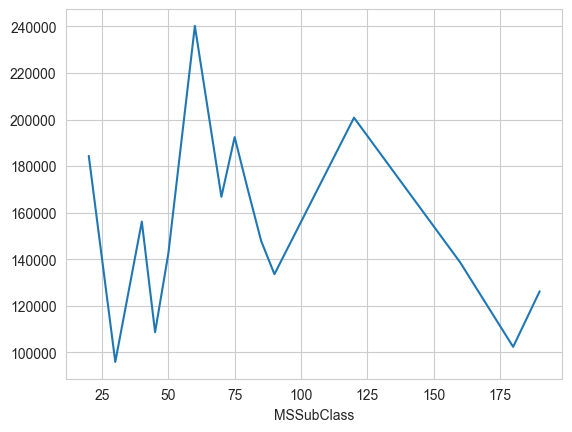

In [68]:
train_data["SalePrice"].groupby(train_data["MSSubClass"]).mean().plot()

<Axes: ylabel='count'>

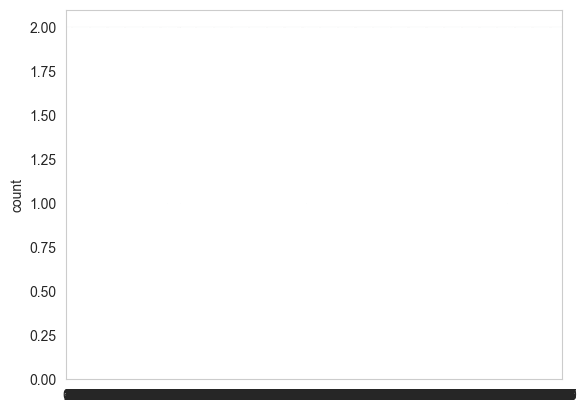

In [69]:
sns.countplot(conbined_data["MSSubClass"])

可以看出价格和销量都与 MSSubClass 存在一定的联系。查看数据描述是因为房屋是否 NEWER！

In [70]:
conbined_data["NewerDwelling"] = conbined_data["MSSubClass"].replace(
    {
        20: 1,
        30: 0,
        40: 0,
        45: 0,
        50: 0,
        60: 1,
        70: 0,
        75: 0,
        80: 0,
        85: 0,
        90: 0,
        120: 1,
        150: 0,
        160: 0,
        180: 0,
        190: 0,
    }
)

In [71]:
# 新增每种类别的平均价格
sale_price_mssc = (
    train_data["SalePrice"].groupby(train_data["MSSubClass"]).mean().to_dict()
)
# 该月卖的平均价格
conbined_data["MSSubClassMeanPrice"] = conbined_data["MSSubClass"].replace(
    sale_price_mssc
)

In [72]:
mssubclass_dict = {
    20: "SC20",
    30: "SC30",
    40: "SC40",
    45: "SC45",
    50: "SC50",
    60: "SC60",
    70: "SC70",
    75: "SC75",
    80: "SC80",
    85: "SC85",
    90: "SC90",
    120: "SC120",
    150: "SC150",
    160: "SC160",
    180: "SC180",
    190: "SC190",
}
conbined_data["MSSubClass"] = conbined_data["MSSubClass"].replace(mssubclass_dict)

对于那些存在大小特质的属性进行编码。

In [74]:
good_level_map = {
    "Street": {"Grvl": 0, "Pave": 1},
    "Alley": {"NA": 0, "Grvl": 1, "Pave": 2},
    "Utilities": {"AllPub": 3, "NoSeWa": 1, "NoSewr": 2, "ELO": 0},
    "ExterQual": {"Ex": 4, "Gd": 3, "TA": 2, "Fa": 1, "Po": 0},
    "ExterCond": {"Ex": 4, "Gd": 3, "TA": 2, "Fa": 1, "Po": 0},
    "BsmtExposure": {"Gd": 4, "Av": 3, "Mn": 2, "No": 1, "NA": 0},
    "BsmtQual": {"Ex": 5, "Gd": 4, "TA": 3, "Fa": 2, "Po": 1, "NA": 0},
    "BsmtCond": {"Ex": 5, "Gd": 4, "TA": 3, "Fa": 2, "Po": 1, "NA": 0},
    "BsmtFinType1": {
        "NA": 0,
        "Unf": 1,
        "LwQ": 2,
        "Rec": 3,
        "BLQ": 4,
        "ALQ": 5,
        "GLQ": 6,
    },
    "BsmtFinType2": {
        "NA": 0,
        "Unf": 1,
        "LwQ": 2,
        "Rec": 3,
        "BLQ": 4,
        "ALQ": 5,
        "GLQ": 6,
    },
    "HeatingQC": {"Ex": 4, "Gd": 3, "TA": 2, "Fa": 1, "Po": 0},
    "CentralAir": {"N": 0, "Y": 1},
    "KitchenQual": {"Ex": 4, "Gd": 3, "TA": 2, "Fa": 1, "Po": 0},
    "Functional": {
        "Typ": 0,
        "Min1": 1,
        "Min2": 1,
        "Mod": 2,
        "Maj1": 3,
        "Maj2": 4,
        "Sev": 5,
        "Sal": 6,
    },
    "FireplaceQu": {"Ex": 5, "Gd": 4, "TA": 3, "Fa": 2, "Po": 1, "NA": 0},
    "GarageQual": {"Ex": 5, "Gd": 4, "TA": 3, "Fa": 2, "Po": 1, "NA": 0},
    "GarageCond": {"Ex": 5, "Gd": 4, "TA": 3, "Fa": 2, "Po": 1, "NA": 0},
    "PoolQC": {"Ex": 4, "Gd": 3, "TA": 2, "Fa": 1, "NA": 0},
    "Fence": {"GdPrv": 2, "GdWo": 2, "MnPrv": 1, "MnWw": 1, "NA": 0},
}

good_level_data = conbined_data[good_level_map.keys()].replace(good_level_map)

good_level_data.columns = good_level_data.columns.map(lambda m: m + "_")

conbined_data[good_level_data.columns] = good_level_data[good_level_data.columns]

Neighborhood 属性表示的是附近的地名，可将其转为经纬度。

In [75]:
# 纬度
conbined_data["latitude"] = conbined_data.Neighborhood.replace(
    {
        "Blmngtn": 42.062806,
        "Blueste": 42.009408,
        "BrDale": 42.052500,
        "BrkSide": 42.033590,
        "ClearCr": 42.025425,
        "CollgCr": 42.021051,
        "Crawfor": 42.025949,
        "Edwards": 42.022800,
        "Gilbert": 42.027885,
        "GrnHill": 42.000854,
        "IDOTRR": 42.019208,
        "Landmrk": 42.044777,
        "MeadowV": 41.991866,
        "Mitchel": 42.031307,
        "NAmes": 42.042966,
        "NoRidge": 42.050307,
        "NPkVill": 42.050207,
        "NridgHt": 42.060356,
        "NWAmes": 42.051321,
        "OldTown": 42.028863,
        "SWISU": 42.017578,
        "Sawyer": 42.033611,
        "SawyerW": 42.035540,
        "Somerst": 42.052191,
        "StoneBr": 42.060752,
        "Timber": 41.998132,
        "Veenker": 42.040106,
    }
)
# 经度
conbined_data["longitude"] = conbined_data.Neighborhood.replace(
    {
        "Blmngtn": -93.639963,
        "Blueste": -93.645543,
        "BrDale": -93.628821,
        "BrkSide": -93.627552,
        "ClearCr": -93.675741,
        "CollgCr": -93.685643,
        "Crawfor": -93.620215,
        "Edwards": -93.663040,
        "Gilbert": -93.615692,
        "GrnHill": -93.643377,
        "IDOTRR": -93.623401,
        "Landmrk": -93.646239,
        "MeadowV": -93.602441,
        "Mitchel": -93.626967,
        "NAmes": -93.613556,
        "NoRidge": -93.656045,
        "NPkVill": -93.625827,
        "NridgHt": -93.657107,
        "NWAmes": -93.633798,
        "OldTown": -93.615497,
        "SWISU": -93.651283,
        "Sawyer": -93.669348,
        "SawyerW": -93.685131,
        "Somerst": -93.643479,
        "StoneBr": -93.628955,
        "Timber": -93.648335,
        "Veenker": -93.657032,
    }
)

# Ames city 的经纬度：经度-93.63191310000002，纬度42.0307812，计算距离
conbined_data["NeighborDistance"] = np.sqrt(
    np.power((conbined_data["longitude"] - (-93.63191310000002)), 2)
    + np.power((conbined_data["latitude"] - 42.0307812), 2)
)

display(conbined_data["NeighborDistance"].head())

conbined_data.drop(["longitude", "latitude"], axis=1, inplace=True)

0    0.054604
1    0.026794
2    0.054604
3    0.012657
4    0.031042
Name: NeighborDistance, dtype: float64

In [76]:
# Bin by neighborhood (a little arbitrarily). Values were computed by:
neighbor_price_map = (
    train_data["SalePrice"]
    .groupby(train_data["Neighborhood"])
    .median()
    .sort_values()
    .to_dict()
)

In [77]:
neighbor_bin_map = {
    "MeadowV": 0,  #  88000
    "IDOTRR": 1,  # 103000
    "BrDale": 1,  # 106000
    "OldTown": 1,  # 119000
    "Edwards": 1,  # 119500
    "BrkSide": 1,  # 124300
    "Sawyer": 1,  # 135000
    "Blueste": 1,  # 137500
    "SWISU": 2,  # 139500
    "NAmes": 2,  # 140000
    "NPkVill": 2,  # 146000
    "Mitchel": 2,  # 153500
    "SawyerW": 2,  # 179900
    "Gilbert": 2,  # 181000
    "NWAmes": 2,  # 182900
    "Blmngtn": 2,  # 191000
    "CollgCr": 2,  # 197200
    "ClearCr": 3,  # 200250
    "Crawfor": 3,  # 200624
    "Veenker": 3,  # 218000
    "Somerst": 3,  # 225500
    "Timber": 3,  # 228475
    "StoneBr": 4,  # 278000
    "NoRidge": 4,  # 290000
    "NridgHt": 4,  # 315000
}

conbined_data["NeighborPrice"] = conbined_data["Neighborhood"].map(neighbor_price_map)
conbined_data["NeighborBin"] = conbined_data["Neighborhood"].map(neighbor_bin_map)

In [78]:
conbined_data.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,KitchenQual_,Functional_,FireplaceQu_,GarageQual_,GarageCond_,PoolQC_,Fence_,NeighborDistance,NeighborPrice,NeighborBin
0,1,SC60,RL,65.0,8450,Pave,NA,Reg,Lvl,AllPub,...,3,0,0,3,3,0,0,0.054604,197200.0,2
1,2,SC20,RL,80.0,9600,Pave,NA,Reg,Lvl,AllPub,...,2,0,3,3,3,0,0,0.026794,218000.0,3
2,3,SC60,RL,68.0,11250,Pave,NA,IR1,Lvl,AllPub,...,3,0,3,3,3,0,0,0.054604,197200.0,2
3,4,SC70,RL,60.0,9550,Pave,NA,IR1,Lvl,AllPub,...,3,0,4,3,3,0,0,0.012657,200624.0,3
4,5,SC60,RL,84.0,14260,Pave,NA,IR1,Lvl,AllPub,...,3,0,3,3,3,0,0,0.031042,301500.0,4


# Create new features

Ref: [juliencs : A study on Regression applied to the Ames dataset
](https://www.kaggle.com/juliencs/house-prices-advanced-regression-techniques/a-study-on-regression-applied-to-the-ames-dataset)
- Create some boolean features
- Simplifications of existing features - Ref
- Combinations of existing features - Ref
- Polynomials on the top 10 existing features - Ref

In [79]:
str_columns = conbined_data.select_dtypes(include=["object"]).columns.values
num_columns = conbined_data.select_dtypes(exclude=["object"]).columns.values

In [80]:
str_columns

array(['MSSubClass', 'MSZoning', 'Street', 'Alley', 'LotShape',
       'LandContour', 'Utilities', 'LotConfig', 'LandSlope',
       'Neighborhood', 'Condition1', 'Condition2', 'BldgType',
       'HouseStyle', 'RoofStyle', 'RoofMatl', 'Exterior1st',
       'Exterior2nd', 'MasVnrType', 'ExterQual', 'ExterCond',
       'Foundation', 'BsmtQual', 'BsmtCond', 'BsmtExposure',
       'BsmtFinType1', 'BsmtFinType2', 'Heating', 'HeatingQC',
       'CentralAir', 'Electrical', 'KitchenQual', 'Functional',
       'FireplaceQu', 'GarageType', 'GarageFinish', 'GarageQual',
       'GarageCond', 'PavedDrive', 'PoolQC', 'Fence', 'MiscFeature',
       'MoSold', 'SaleType', 'SaleCondition'], dtype=object)

1.Create some boolean features

<Axes: xlabel='count', ylabel='SaleCondition'>

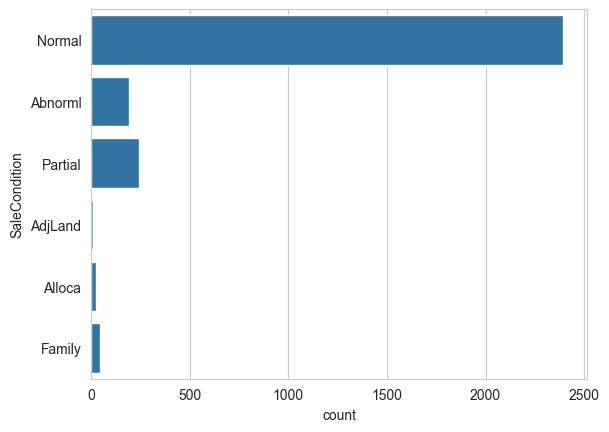

In [82]:
# test str column
column = "SaleCondition"
count_duct = {}
for key in set(conbined_data[column]):
    count_duct[key] = 0

for m in conbined_data[column].values:
    count_duct[str(m)] = count_duct[str(m)] + 1

count_duct = sorted(count_duct.items(), key=lambda d: d[1], reverse=True)
sns.countplot(conbined_data[column])

In [83]:
# IR2 and IR3 don't appear that often, so just make a distinction
# between regular and irregular.
conbined_data["IsRegularLotShape"] = (conbined_data["LotShape"] == "Reg") * 1

# Bnk, Low, HLS don't appear that often, so just make a distinction
conbined_data["IsLandContourLvl"] = (conbined_data["LandContour"] == "Lvl") * 1
conbined_data["IsLotConfigInside"] = (conbined_data["LotConfig"] == "Inside") * 1
conbined_data["IsLandSlopeGentle"] = (conbined_data["LandSlope"] == "Gtl") * 1
conbined_data["IsCondition1Norm"] = (conbined_data["Condition1"] == "Norm") * 1
conbined_data["IsCondition2Norm"] = (conbined_data["Condition2"] == "Norm") * 1
conbined_data["IsBldgType1Fam"] = (conbined_data["BldgType"] == "1Fam") * 1
conbined_data["IsRoofStyleGable"] = (conbined_data["RoofStyle"] == "Gable") * 1
conbined_data["IsRoofMatlCompShg"] = (conbined_data["RoofMatl"] == "CompShg") * 1
conbined_data["IsGasAHeating"] = (conbined_data["Heating"] == "GasA") * 1
conbined_data["IsGarageFinished"] = (conbined_data["GarageFinish"] == "Fin") * 1
conbined_data["IsPavedDrive"] = (conbined_data["PavedDrive"] == "Y") * 1
conbined_data["IsSaleTypeWD"] = (conbined_data["SaleType"] == "WD") * 1
conbined_data["IsSaleConditionNormal"] = (
    conbined_data["SaleCondition"] == "Normal"
) * 1

In [84]:
# The only interesting "misc. feature" is the presence of a shed.
conbined_data["HasShed"] = (conbined_data["MiscFeature"] == "Shed") * 1.0

# Was this house sold in the year it was built?
conbined_data["IsVeryNewHouse"] = (
    conbined_data["YearBuilt"] == conbined_data["YrSold"]
) * 1

conbined_data["Has2ndFloor"] = (conbined_data["2ndFlrSF"] == 0) * 1
conbined_data["HasMasVnr"] = (conbined_data["MasVnrArea"] == 0) * 1
conbined_data["HasWoodDeck"] = (conbined_data["WoodDeckSF"] == 0) * 1
conbined_data["HasOpenPorch"] = (conbined_data["OpenPorchSF"] == 0) * 1
conbined_data["HasEnclosedPorch"] = (conbined_data["EnclosedPorch"] == 0) * 1
conbined_data["Has3SsnPorch"] = (conbined_data["3SsnPorch"] == 0) * 1
conbined_data["HasScreenPorch"] = (conbined_data["ScreenPorch"] == 0) * 1

In [85]:
# 2.Simplifications of existing features
conbined_data["SimplOverallQual"] = conbined_data.OverallQual.replace(
    {
        1: 1,
        2: 1,
        3: 1,  # bad
        4: 2,
        5: 2,
        6: 2,  # average
        7: 3,
        8: 3,
        9: 3,
        10: 3,  # good
    }
)
conbined_data["SimplOverallCond"] = conbined_data.OverallCond.replace(
    {
        1: 1,
        2: 1,
        3: 1,  # bad
        4: 2,
        5: 2,
        6: 2,  # average
        7: 3,
        8: 3,
        9: 3,
        10: 3,  # good
    }
)

In [86]:
# 3.Combinations of existing features

# Overall quality of the house
conbined_data["OverallGrade"] = (
    conbined_data["OverallQual"] * conbined_data["OverallCond"]
)
# Overall quality of the garage
conbined_data["GarageGrade"] = (
    conbined_data["GarageQual_"] * conbined_data["GarageCond"]
)
# Overall quality of the exterior
conbined_data["ExterGrade"] = conbined_data["ExterQual_"] * conbined_data["ExterCond"]
# Overall kitchen score
conbined_data["KitchenScore"] = (
    conbined_data["KitchenAbvGr"] * conbined_data["KitchenQual_"]
)
# Overall fireplace score
conbined_data["FireplaceScore"] = (
    conbined_data["Fireplaces"] * conbined_data["FireplaceQu_"]
)
# Overall garage score
conbined_data["GarageScore"] = (
    conbined_data["GarageArea"] * conbined_data["GarageQual_"]
)
# Overall pool score
conbined_data["PoolScore"] = conbined_data["PoolArea"] * conbined_data["PoolQC_"]

# Total number of bathrooms
conbined_data["TotalBath"] = (
    conbined_data["BsmtFullBath"]
    + (0.5 * conbined_data["BsmtHalfBath"])
    + conbined_data["FullBath"]
    + (0.5 * conbined_data["HalfBath"])
)

# Total yard area in square feet
conbined_data["TotalPorchSF"] = (
    conbined_data["OpenPorchSF"]
    + conbined_data["EnclosedPorch"]
    + conbined_data["3SsnPorch"]
    + conbined_data["ScreenPorch"]
)
# Total SF for house (living, basement, porch, pool)
conbined_data["AllSF"] = (
    conbined_data["GrLivArea"]
    + conbined_data["TotalBsmtSF"]
    + conbined_data["TotalPorchSF"]
    + conbined_data["WoodDeckSF"]
    + conbined_data["PoolArea"]
)

# House completed before sale or not
conbined_data["BoughtOffPlan"] = conbined_data.SaleCondition.replace(
    {"Abnorml": 0, "Alloca": 0, "AdjLand": 0, "Family": 0, "Normal": 0, "Partial": 1}
)

In [87]:
# 4.Polynomials on the top n existing features
train_data_new = conbined_data.iloc[:train_length, :]
# 添加价格
train_data_new.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,GarageGrade,ExterGrade,KitchenScore,FireplaceScore,GarageScore,PoolScore,TotalBath,TotalPorchSF,AllSF,BoughtOffPlan
0,1,SC60,RL,65.0,8450,Pave,NA,Reg,Lvl,AllPub,...,TATATA,TATATA,3,0,1644.0,0,3.5,61,2627.0,0
1,2,SC20,RL,80.0,9600,Pave,NA,Reg,Lvl,AllPub,...,TATATA,TATA,2,3,1380.0,0,2.5,0,2822.0,0
2,3,SC60,RL,68.0,11250,Pave,NA,IR1,Lvl,AllPub,...,TATATA,TATATA,3,3,1824.0,0,3.5,42,2748.0,0
3,4,SC70,RL,60.0,9550,Pave,NA,IR1,Lvl,AllPub,...,TATATA,TATA,3,4,1926.0,0,2.0,307,2780.0,0
4,5,SC60,RL,84.0,14260,Pave,NA,IR1,Lvl,AllPub,...,TATATA,TATATA,3,3,2508.0,0,3.5,84,3619.0,0


Text(0, 0.5, 'Feature Importance Score')

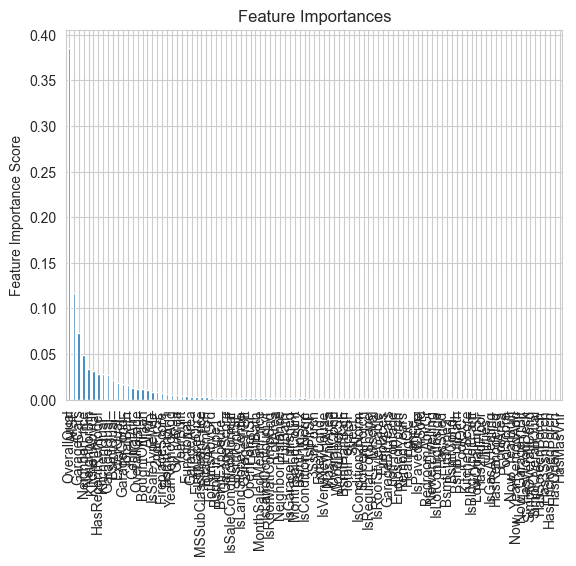

In [88]:
from xgboost import XGBRegressor

train_Y = train_data["SalePrice"]
train_X = train_data_new.select_dtypes(exclude=["object"]).drop(["Id"], axis=1)

xgb_regressor = XGBRegressor(seed=10)
xgb_regressor.fit(train_X, train_Y)

feature_importances = pd.Series(
    xgb_regressor.feature_importances_, train_X.columns.values
)
feature_importances = feature_importances.sort_values(ascending=False)
# feature_importances= feature_importances.head(40)
feature_importances.plot(kind="bar", title="Feature Importances")
plt.ylabel("Feature Importance Score")

In [89]:
top_n = 15
poly_columns = feature_importances.index.values[:top_n]
for column in poly_columns:
    conbined_data[column + "-s2"] = conbined_data[column] ** 2
    conbined_data[column + "-s3"] = conbined_data[column] ** 3
    conbined_data[column + "-sq"] = np.sqrt(conbined_data[column])

In [90]:
conbined_data.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,GarageCond_-sq,TotalBath-s2,TotalBath-s3,TotalBath-sq,CentralAir_-s2,CentralAir_-s3,CentralAir_-sq,OverallGrade-s2,OverallGrade-s3,OverallGrade-sq
0,1,SC60,RL,65.0,8450,Pave,NA,Reg,Lvl,AllPub,...,1.732051,12.25,42.875,1.870829,1,1,1.0,1225,42875,5.916080
1,2,SC20,RL,80.0,9600,Pave,NA,Reg,Lvl,AllPub,...,1.732051,6.25,15.625,1.581139,1,1,1.0,2304,110592,6.928203
2,3,SC60,RL,68.0,11250,Pave,NA,IR1,Lvl,AllPub,...,1.732051,12.25,42.875,1.870829,1,1,1.0,1225,42875,5.916080
3,4,SC70,RL,60.0,9550,Pave,NA,IR1,Lvl,AllPub,...,1.732051,4.00,8.000,1.414214,1,1,1.0,1225,42875,5.916080
4,5,SC60,RL,84.0,14260,Pave,NA,IR1,Lvl,AllPub,...,1.732051,12.25,42.875,1.870829,1,1,1.0,1600,64000,6.324555


** Feature Scale / Skew **

Ref: [Lasso model for regression problem](https://www.kaggle.com/klyusba/house-prices-advanced-regression-techniques/lasso-model-for-regression-problem/notebook)

![](http://itknowledgeexchange.techtarget.com/writing-for-business/files/2012/12/skewness-300x247.png)

In [91]:
str_columns = conbined_data.select_dtypes(include=["object"]).columns.values
num_columns = conbined_data.select_dtypes(exclude=["object"]).columns.values[1:]

In [92]:
num_columns

array(['LotFrontage', 'LotArea', 'OverallQual', 'OverallCond',
       'YearBuilt', 'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1',
       'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF',
       'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath',
       'FullBath', 'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr',
       'TotRmsAbvGrd', 'Fireplaces', 'GarageYrBlt', 'GarageCars',
       'GarageArea', 'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch',
       '3SsnPorch', 'ScreenPorch', 'PoolArea', 'MiscVal', 'YrSold',
       'RemodYears', 'HasRemodeled', 'HasRecentRemodel', 'GarageBltYears',
       'Now_YearBuilt', 'Now_YearRemodAdd', 'Now_GarageYrBlt',
       'MonthSaledMeanPrice', 'MonthSaledCount', 'NewerDwelling',
       'MSSubClassMeanPrice', 'Street_', 'Alley_', 'Utilities_',
       'ExterQual_', 'ExterCond_', 'BsmtExposure_', 'BsmtQual_',
       'BsmtCond_', 'BsmtFinType1_', 'BsmtFinType2_', 'HeatingQC_',
       'CentralAir_', 'KitchenQual_', 'Functional_', 'FireplaceQu_

In [94]:
scater_skew_num_columns = num_columns.tolist()
for column in num_columns:
    # for boolean features, do not scatter and skewed
    if set(conbined_data[column]) == {0, 1}:
        scater_skew_num_columns.remove(column)

In [95]:
t = conbined_data[scater_skew_num_columns].quantile(0.95)
use_max_scater = t[t == 0].index
use_95_scater = t[t != 0].index
conbined_data[use_max_scater] = (
    conbined_data[use_max_scater] / conbined_data[use_max_scater].max()
)
conbined_data[use_95_scater] = conbined_data[use_95_scater] / conbined_data[
    use_95_scater
].quantile(0.95)

In [97]:
# Transform the skewed numeric features by taking log(feature + 1).
# This will make the features more normal.
from scipy.stats import skew

skewed = conbined_data[scater_skew_num_columns].apply(lambda x: skew(x.astype(float)))
skewed = skewed[skewed > 0.75]
skewed = skewed.index
skewed = skewed.drop(["NeighborPrice", "NeighborPrice-s2", "NeighborPrice-s3"])
print(
    "skewed features",
    skewed.shape[0],
    " from total ",
    conbined_data.shape[1],
    " features",
)
conbined_data[skewed] = np.log1p(conbined_data[skewed])

skewed features 54  from total  194  features


In [98]:
price_feature = [
    "MonthSaledMeanPrice",
    "MSSubClassMeanPrice",
    "NeighborPrice",
    "NeighborPrice-s2",
    "NeighborPrice-s3",
    "NeighborPrice-sq",
]
conbined_data[price_feature] = np.log1p(conbined_data[price_feature])

In [99]:
conbined_data.shape

(2911, 194)

** Dummy Encoding **

In [100]:
str_columns

array(['MSSubClass', 'MSZoning', 'Street', 'Alley', 'LotShape',
       'LandContour', 'Utilities', 'LotConfig', 'LandSlope',
       'Neighborhood', 'Condition1', 'Condition2', 'BldgType',
       'HouseStyle', 'RoofStyle', 'RoofMatl', 'Exterior1st',
       'Exterior2nd', 'MasVnrType', 'ExterQual', 'ExterCond',
       'Foundation', 'BsmtQual', 'BsmtCond', 'BsmtExposure',
       'BsmtFinType1', 'BsmtFinType2', 'Heating', 'HeatingQC',
       'CentralAir', 'Electrical', 'KitchenQual', 'Functional',
       'FireplaceQu', 'GarageType', 'GarageFinish', 'GarageQual',
       'GarageCond', 'PavedDrive', 'PoolQC', 'Fence', 'MiscFeature',
       'MoSold', 'SaleType', 'SaleCondition', 'GarageGrade', 'ExterGrade'],
      dtype=object)

In [101]:
dummies_data = pd.get_dummies(conbined_data[str_columns])
conbined_data[dummies_data.columns] = dummies_data[dummies_data.columns]
conbined_data.drop(str_columns, axis=1, inplace=True)

In [102]:
conbined_data.shape

(2911, 471)

Delete some features to prevent overfitting.

In [103]:
# These onehot columns are missing in the test data, so drop them from the
# training data or we might overfit on them.
drop_cols = [
    "Exterior1st_ImStucc",
    "Exterior1st_Stone",
    "Exterior2nd_Other",
    "HouseStyle_2.5Fin",
    "RoofMatl_Membran",
    "RoofMatl_Metal",
    "RoofMatl_Roll",
    "Condition2_RRAe",
    "Condition2_RRAn",
    "Condition2_RRNn",
    "Heating_Floor",
    "Heating_OthW",
    "Electrical_Mix",
    "MiscFeature_TenC",
    "GarageQual_Ex",
    "PoolQC_Fa",
]

conbined_data.drop(drop_cols, axis=1, inplace=True)

In [104]:
conbined_data.shape

(2911, 455)

In [105]:
train_X = conbined_data.iloc[:train_length, 1:]
train_Y = train_data["SalePrice"]
train_Id = conbined_data.iloc[:train_length, 0]

test_X = conbined_data.iloc[train_length:, 1:]
test_Id = conbined_data.iloc[train_length:, 0]

print("train_X : " + str(train_X.shape))
print("test_X : " + str(test_X.shape))
print("train_Y : " + str(train_Y.shape))

train_X : (1452, 454)
test_X : (1459, 454)
train_Y : (1452,)


(array([  5.,  12.,  54., 184., 469., 400., 215.,  88.,  19.,   6.]),
 array([10.46027076, 10.76769112, 11.07511148, 11.38253184, 11.6899522 ,
        11.99737256, 12.30479292, 12.61221328, 12.91963363, 13.22705399,
        13.53447435]),
 <BarContainer object of 10 artists>)

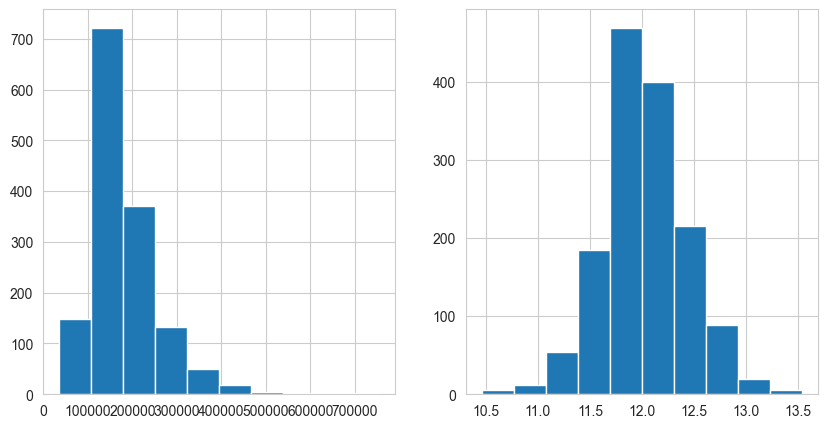

In [106]:
# 价格分布
fig, (axis1, axis2) = plt.subplots(1, 2, figsize=(10, 5))
axis1.hist(train_Y)
# Transform skewed numeric features using log(p+1) transformation making them more normal
train_Y = np.log1p(train_Y)
axis2.hist(train_Y)

# Save New Data

In [108]:
save_train = train_X.copy()
save_test = test_X.copy()
save_train["Id"] = train_Id
save_train["SalePrice"] = train_Y
save_test["Id"] = test_Id

display(save_train.head())
display(save_test.head())

save_train.to_csv("data/new_train.csv", index=False)
save_test.to_csv("data/new_test.csv", index=False)

,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,...,ExterGrade_GdGdGd,ExterGrade_GdGdGdGd,ExterGrade_Po,ExterGrade_PoPo,ExterGrade_TA,ExterGrade_TATA,ExterGrade_TATATA,ExterGrade_TATATATA,Id,SalePrice
0,0.625000,0.405761,0.875,0.625,0.998007,0.998007,0.353963,0.440935,0.0,0.096725,...,False,False,False,False,False,False,True,False,1,12.247699
1,0.769231,0.450153,0.750,1.000,0.984554,0.984554,0.000000,0.569657,0.0,0.175869,...,False,False,False,False,False,True,False,False,2,12.109016
2,0.653846,0.510589,0.875,0.625,0.997010,0.997509,0.300867,0.323152,0.0,0.257614,...,False,False,False,False,False,False,True,False,3,12.317171
3,0.576923,0.448263,0.875,0.625,0.954160,0.981565,0.000000,0.156615,0.0,0.311598,...,False,False,False,False,False,True,False,False,4,11.849405
4,0.807692,0.612228,1.000,0.625,0.996512,0.996512,0.564402,0.414840,0.0,0.286497,...,False,False,False,False,False,False,True,False,5,12.429220


,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,...,ExterGrade_GdGd,ExterGrade_GdGdGd,ExterGrade_GdGdGdGd,ExterGrade_Po,ExterGrade_PoPo,ExterGrade_TA,ExterGrade_TATA,ExterGrade_TATATA,ExterGrade_TATATATA,Id
0,0.769231,0.523724,0.625,0.750,0.977080,0.977080,0.000000,0.312872,0.286817,0.167887,...,False,False,False,False,False,False,True,False,False,1461
1,0.778846,0.612453,0.750,0.750,0.975585,0.975585,0.210277,0.544931,0.000000,0.242853,...,False,False,False,False,False,False,True,False,False,1462
2,0.711538,0.598325,0.625,0.625,0.995017,0.995516,0.000000,0.482969,0.000000,0.088703,...,False,False,False,False,False,False,True,False,False,1463
3,0.750000,0.464324,0.750,0.750,0.995516,0.995516,0.042424,0.386980,0.000000,0.198329,...,False,False,False,False,False,False,True,False,False,1464
4,0.413462,0.259604,1.000,0.625,0.992526,0.992526,0.000000,0.187671,0.000000,0.523875,...,False,False,False,False,False,False,False,True,False,1465
